# Ablation Study (애블레이션 연구, 제거 연구)
- **제거**한 모델로 수행한 실험과 추가한 모델로 수행한 실험의 결과 비교
- ResNet 논문에서 제시한 **residual connection의 애블레이션 연구**

## Ablation Study 실습 CIFAR-10 데이터셋 준비하기
- CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인한다

### 패키지 설치

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### gpu 장착 확인하기

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 불러오기 (시간이 오래걸린다 한번 불러오면 된다)

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


### feature 정보 확인하기

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


### 데이터 개수 확인하기

In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## input Normalization
- **Data Normalization**은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것이다
- Data Normalization을 하는 이유
 - 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지한다
 - 딥러닝에서 Local optimum에 빠질 위험을 줄인다

- 아래 그림을 보면 왼쪽이 정규화 하지 않은 경우의 Cost function 이고 오른쪽이 정규화 한 Cost function 일 때, 정규화 한 경우가 Local optimum 에서 더 빨리 빠져나올 수 있다는 것을 직관적으로 이해할 수 있다
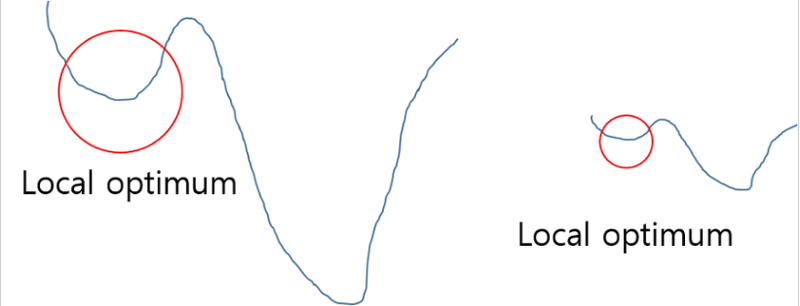

### 정규화 코드 작성하기

In [6]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 클래스 구성요소 확인하기

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

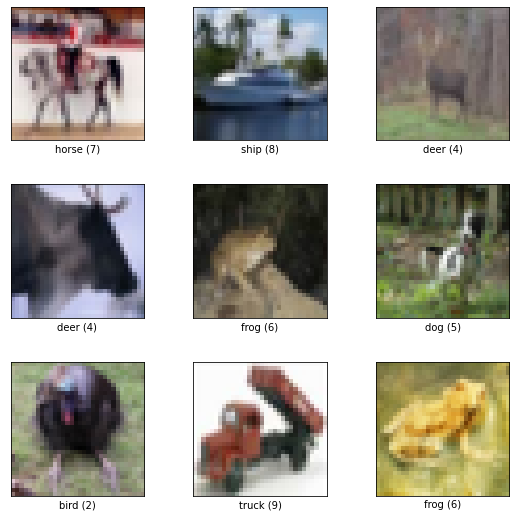

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

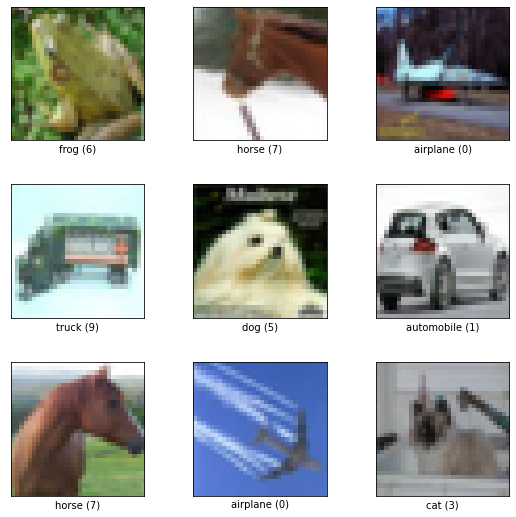

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 블록 구성하기
- 구현 시에 반복되는 부분을 줄여서 하이퍼 파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 중요하다
- **주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 block(블록)**이라고 부른다

### VGG 기본 블록 만들기
- VGG의 블록은 cnn 레이어 여러 개와 Max pooling 레이어 한개로 이루어져 있다

### 기본적인 블록을 만들 수 있는 함수를 만들었다

In [12]:
# function for building VGG Block
# VGG 블록을 생성하는 함수 정의
def build_vgg_block(input_layer,  # 입력 레이어
                    num_cnn=3,    # CNN 레이어의 개수, 기본값은 3
                    channel=64,   # 각 CNN 레이어의 필터 개수, 기본값은 64
                    block_num=1,  # 블록 번호, 디버깅 및 네이밍에 사용
                   ):
    # 입력 레이어
    # 입력 레이어를 x 변수에 할당 (초기값)
    x = input_layer

    # CNN 레이어
    # num_cnn에 지정된 개수만큼 CNN 레이어 추가
    for cnn_num in range(num_cnn):
        # Conv2D: 2D convolutional layer 추가
        x = keras.layers.Conv2D(
            filters=channel,          # 필터 개수 (channel)
            kernel_size=(3,3),        # 커널 크기 (3x3)
            activation='relu',        # 활성화 함수 (ReLU)
            kernel_initializer='he_normal',  # 가중치 초기화 방식 (He normal 초기화)
            padding='same',           # 출력 크기를 입력 크기와 동일하게 유지 (패딩 추가)
            name=f'block{block_num}_conv{cnn_num}'  # 레이어 이름 지정 (블록 및 레이어 번호 포함)
        )(x)    

    # Max Pooling 레이어
    # CNN 레이어가 끝난 후 MaxPooling 레이어 추가
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),  # 풀링 윈도우 크기 (2x2)
        strides=2,         # 풀링 윈도우의 이동 간격 (stride)
        name=f'block{block_num}_pooling'  # 레이어 이름 지정 (블록 번호 포함)
    )(x)

    # 최종 출력 레이어 반환
    return x


In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## VGG complete model
### VGG-16
- 작은 네트워크인 VGG-16을 만들어보자

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-19
- 구성을 바꾸어 VGG-19를 만들어보자

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### CIFAR-10 데이터셋 불러오기

In [18]:
BATCH_SIZE = 256
EPOCH = 15

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### VGG-16 모델 훈련하기

In [20]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 148s 612ms/step - loss: 2.1874 - accuracy: 0.1855 - val_loss: 2.0659 - val_accuracy: 0.2478
Epoch 2/15
195/195 [==============================] - 105s 540ms/step - loss: 2.0081 - accuracy: 0.2659 - val_loss: 1.9242 - val_accuracy: 0.3129
Epoch 3/15
195/195 [==============================] - 112s 573ms/step - loss: 1.8817 - accuracy: 0.3211 - val_loss: 1.8361 - val_accuracy: 0.3396
Epoch 4/15
195/195 [==============================] - 108s 553ms/step - loss: 1.7763 - accuracy: 0.3622 - val_loss: 1.7106 - val_accuracy: 0.3964
Epoch 5/15
195/195 [==============================] - 111s 571ms/step - loss: 1.6837 - accuracy: 0.3930 - val_loss: 1.6286 - val_accuracy: 0.4093
Epoch 6/15
195/195 [==============================] - 111s 569ms/step - loss: 1.6143 - accuracy: 0.4180 - val_loss: 1.5822 - val_accuracy: 0.4359
Epoch 7/15
195/195 [==============================] - 112s 574ms/step - loss: 1.5740 - accuracy: 0.4322 - val_loss: 1.5127 -

### VGG-19 모델 훈련하기

In [21]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 87s 412ms/step - loss: 2.2588 - accuracy: 0.1630 - val_loss: 2.1710 - val_accuracy: 0.2095
Epoch 2/15
  7/195 [>.............................] - ETA: 1:01 - loss: 2.1901 - accuracy: 0.2037

KeyboardInterrupt: 

### 훈련 소실 비교하기

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

### 정확도 비교하기

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()